In [2]:
from typing import List, Mapping
from itertools import zip_longest, chain
from glob import iglob
from pickle import load
from functools import partial, reduce

from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File
import altair as alt

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

In [3]:
runs = range(292, 298+1)
filenames = sorted(chain.from_iterable(iglob(f"Data/Run_{r:03d}/work/reduced.pickle") for r in runs if not r in {}))
print(f"Total {len(filenames)} files:")
for fn in filenames:
    print(f"    {fn}")

Total 4 files:
    Data/Run_293/work/reduced.pickle
    Data/Run_294/work/reduced.pickle
    Data/Run_295/work/reduced.pickle
    Data/Run_298/work/reduced.pickle


In [4]:
def read_file(filename):
    with open(filename, 'br') as f:
        return load(f)


sumup = partial(reduce, partial(pd.DataFrame.add, fill_value=0))
summed = sumup(read_file(fn) for fn in filenames)
summed

sum    count
is_bg delay atmax                                                            
False -6.78 520    [[99.0, 99.0, 103.0, 108.0, 113.0, 104.0, 103....      1.0
            530    [[2050.0, 2074.0, 2060.0, 2093.0, 2101.0, 2025...     19.0
            535    [[13559.0, 13516.0, 13321.0, 13578.0, 13673.0,...    124.0
            540    [[260821.0, 260531.0, 258582.0, 261940.0, 2633...   2395.0
            545    [[934369.0, 930571.0, 927412.0, 939749.0, 9437...   8692.0
            550    [[942597.0, 934271.0, 934882.0, 946897.0, 9511...   8905.0
            555    [[875191.0, 867134.0, 868609.0, 878471.0, 8832...   8321.0
            560    [[724798.0, 720548.0, 719546.0, 728325.0, 7327...   6804.0
            565    [[1318582.0, 1316112.0, 1308360.0, 1325944.0, ...  12108.0
            570    [[1780581.0, 1775499.0, 1765916.0, 1790473.0, ...  16297.0
            575    [[1329370.0, 1327969.0, 1319455.0, 1336829.0, ...  12205.0
            580    [[366058.0, 364117.0, 362906.0, 367974.0, 3697...   3382.0
            585    [[537.0, 554.0, 549.0, 537.0, 549.0, 522.0, 53...      5.0
            590    [[1728.0, 1729.0, 1702.0, 1720.0, 1724.0, 1696...     16.0
            595    [[445.0, 410.0, 422.0, 425.0, 437.0, 431.0, 44...      4.0
True  -6.78 530    [[1502.0, 1543.0, 1492.0, 1499.0, 1502.0, 1474...     14.0
            535    [[7808.0, 7809.0, 7750.0, 7874.0, 7885.0, 7664...     73.0
            540    [[133447.0, 132404.0, 132126.0, 133982.0, 1348...   1248.0
            545    [[457811.0, 455029.0, 454290.0, 460074.0, 4618...   4316.0
            550    [[472992.0, 469183.0, 469541.0, 475509.0, 4773...   4502.0
            555    [[433794.0, 427765.0, 430474.0, 434931.0, 4370...   4143.0
            560    [[355774.0, 352594.0, 353734.0, 357605.0, 3591...   3376.0
            565    [[651347.0, 648105.0, 646128.0, 654821.0, 6567...   6091.0
            570    [[872416.0, 867458.0, 865933.0, 877295.0, 8808...   8155.0
            575    [[641124.0, 637982.0, 636252.0, 644716.0, 6475...   6001.0
            580    [[180507.0, 178931.0, 178840.0, 181480.0, 1822...   1694.0
            585    [[315.0, 305.0, 320.0, 317.0, 312.0, 310.0, 31...      3.0
            590    [[1376.0, 1363.0, 1385.0, 1376.0, 1397.0, 1361...     13.0
            595    [[210.0, 205.0, 215.0, 207.0, 216.0, 215.0, 20...      2.0

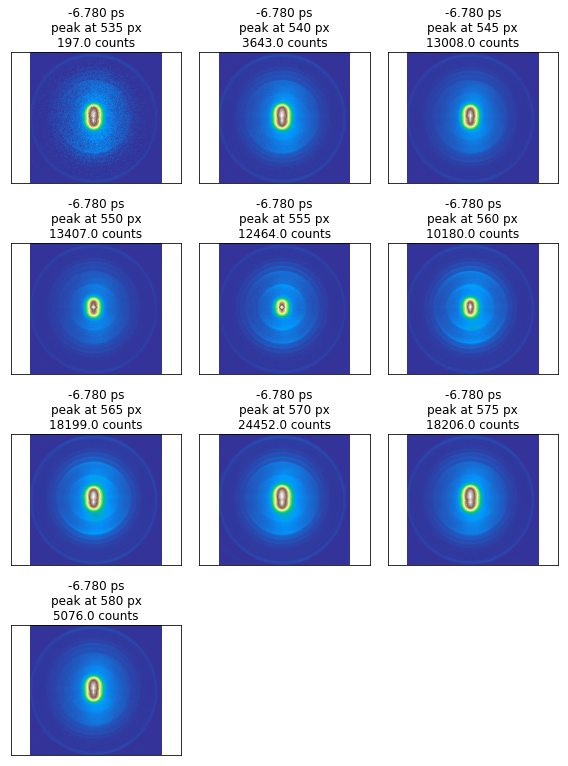

In [5]:
def good_img(img):
    return not np.isnan(img).any()


n = summed['count'].loc[False] + summed['count'].loc[True]
avg = summed['sum'] / summed['count']
diff = (avg.loc[False] - avg.loc[True])
where = (50 < n) & (diff.apply(good_img))
df = pd.DataFrame({
    'img': diff[where].apply(partial(np.einsum, 'ij->ji')),
    'n': n[where],
})

plt.figure(figsize=(8, 16))
for i, ((dt, atmax), img, n) in enumerate(df[['img', 'n']].itertuples()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax} px\n{n} counts")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

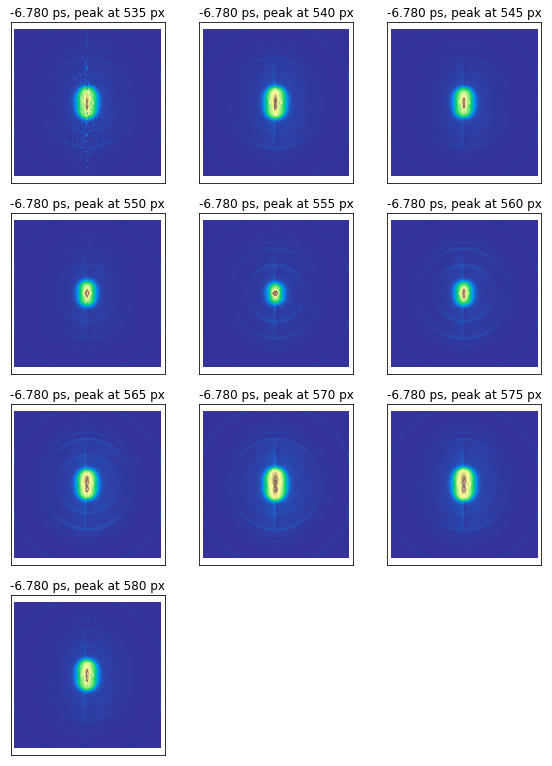

In [6]:
zedges = np.arange(-400, 400 + 1)
redges, thedges = np.linspace(0, 400, 400 + 1), np.linspace(-np.pi, np.pi, 360 + 1)
r = (redges[1:] + redges[:-1]) / 2
th = (thedges[1:] + thedges[:-1]) / 2


def invert_img(d):
    img = d['img']
    img = gaussian_filter(img, 2)
    xn, yn = img.shape
    xedges = np.arange(xn + 1)
    yedges = np.arange(yn + 1)
    f = interp(img, xedges, yedges)
    g = transpose_linearly(f, np.eye(2), x0=np.array([437, 458]))
    transformed = tohist(g, zedges, zedges)

    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    return pd.Series({
        'inverted': inverted,
        'hist_indrdth': hist_indrdth,
        'hist_indrdomega': hist_indrdomega,
    })


df = df.merge(df.apply(invert_img, axis=1), left_index=True, right_index=True)


plt.figure(figsize=(8, 16))
for i, ((dt, atmax), img, n) in enumerate(df[['inverted', 'n']].itertuples()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps, peak at {atmax} px")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

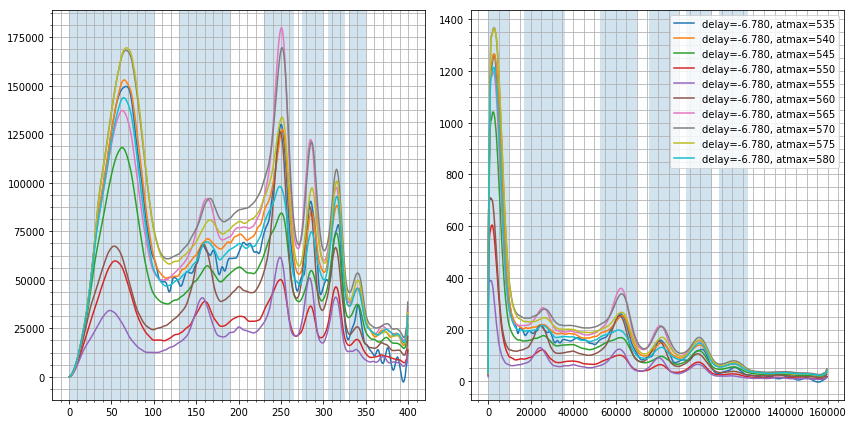

In [7]:
roi = {
    "a1": (0, 100),
    "x4": (130, 190),
    "x2": (230, 265),
    "x1": (275, 300),
    "x0": (305, 325),
    "unknown": (330, 350),
}


def intergrateit(hist, fr, to, x=None, **kwargs):
    if x is None:
        x = np.arange(len(hist))
    where = (fr < x) & (x < to)
    return hist[where].sum(**kwargs)


def project_to_pn(hist, n):
    _, coeff, _ = finite_legendre_transform_in_theta(
        hist, thedges, n + 1,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return coeff[n]/coeff[0]


for k, (fr, to) in roi.items():
    df[f'summed_{k}_rdist'] = df['hist_indrdth'].apply(intergrateit, fr=fr, to=to, x=r)
    df[f'summed_{k}_pad'] = df['hist_indrdomega'].apply(intergrateit, fr=fr, to=to, x=r, axis=0)
    df[f'summed_{k}_beta2'] = df[f'summed_{k}_pad'].apply(project_to_pn, n=2)
    df[f'summed_{k}_beta4'] = df[f'summed_{k}_pad'].apply(project_to_pn, n=4)


def f(hist):
    return hist.sum(1)


plt.figure(figsize=(12, 6))
plt.subplot(121)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r, dist, label=f"delay={dt:.3f},atmax={atmax}")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi.values():
    plt.axvspan(fr, to, alpha=0.2)

plt.subplot(122)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r**2, dist/2/r, label=f"delay={dt:.3f}, atmax={atmax}")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi.values():
    plt.axvspan(fr**2, to**2, alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

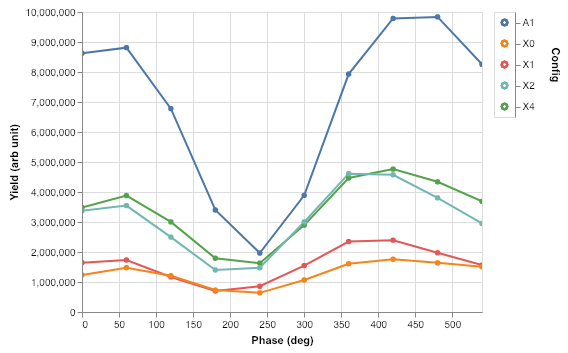

In [12]:
df["Phase (deg)"] = (df.index.to_frame()["atmax"] - 535) / 30 * 360
src = (
    df
    [[
        'Phase (deg)',
        'summed_a1_rdist',
        'summed_x4_rdist',
        'summed_x2_rdist',
        'summed_x1_rdist',
        'summed_x0_rdist',
    ]]
    .rename(columns={
        "summed_a1_rdist": "A1",
        "summed_x4_rdist": "X4",
        "summed_x2_rdist": "X2",
        "summed_x1_rdist": "X1",
        "summed_x0_rdist": "X0",
    })
    .melt("Phase (deg)", var_name="Config", value_name="Yield")
)

select = alt.selection_multi(fields=['Config'])
color = alt.condition(select, alt.Color("Config:N", legend=None), alt.value('lightgray'))
main = alt.Chart(src).mark_line(point=True).encode(
    alt.X("Phase (deg):Q", scale=alt.Scale(zero=False, nice=False)),
    alt.Y("Yield:Q", title="Yield (arb unit)"),
    color=color,
).interactive(bind_x=False)
legend = alt.Chart(src).mark_point().encode(
    alt.Y("Config:N", axis=alt.Axis(orient="right")),
    color=color,
).add_selection(select)

main | legend

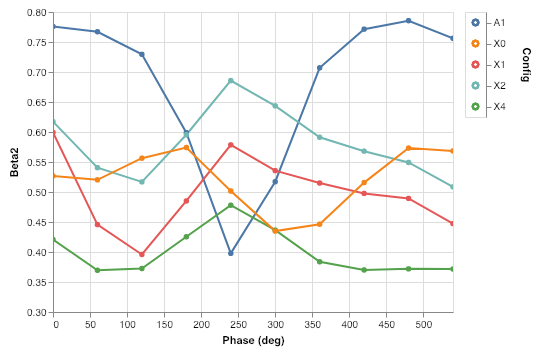

In [9]:
df["Phase (deg)"] = (df.index.to_frame()["atmax"] - 535) / 30 * 360
src = (
    df
    [[
        'Phase (deg)',
        'summed_a1_beta2',
        'summed_x4_beta2',
        'summed_x2_beta2',
        'summed_x1_beta2',
        'summed_x0_beta2',
    ]]
    .rename(columns={
        "summed_a1_beta2": "A1",
        "summed_x4_beta2": "X4",
        "summed_x2_beta2": "X2",
        "summed_x1_beta2": "X1",
        "summed_x0_beta2": "X0",
    })
    .melt("Phase (deg)", var_name="Config", value_name="Beta2")
)

select = alt.selection_multi(fields=['Config'])
color = alt.condition(select, alt.Color("Config:N", legend=None), alt.value('lightgray'))
main = alt.Chart(src).mark_line(point=True).encode(
    alt.X("Phase (deg):Q", scale=alt.Scale(zero=False, nice=False)),
    alt.Y("Beta2:Q", scale=alt.Scale(domain=[0.3, 0.8], nice=False)),
    color=color,
).interactive(bind_x=False)
legend = alt.Chart(src).mark_point().encode(
    y=alt.Y("Config:N", axis=alt.Axis(orient="right")),
    color=color,
).add_selection(select)

main | legend

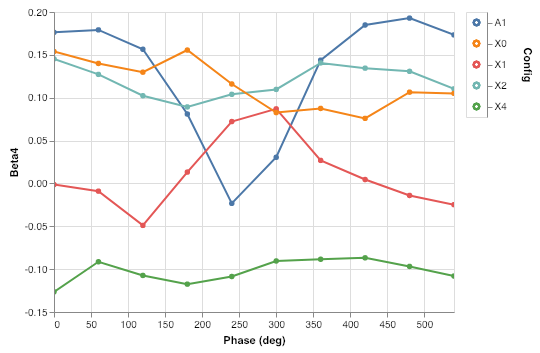

In [10]:
df["Phase (deg)"] = (df.index.to_frame()["atmax"] - 535) / 30 * 360
src = (
    df
    [[
        'Phase (deg)',
        'summed_a1_beta4',
        'summed_x4_beta4',
        'summed_x2_beta4',
        'summed_x1_beta4',
        'summed_x0_beta4',
    ]]
    .rename(columns={
        "summed_a1_beta4": "A1",
        "summed_x4_beta4": "X4",
        "summed_x2_beta4": "X2",
        "summed_x1_beta4": "X1",
        "summed_x0_beta4": "X0",
    })
    .melt("Phase (deg)", var_name="Config", value_name="Beta4")
)

select = alt.selection_multi(fields=['Config'])
color = alt.condition(select, alt.Color("Config:N", legend=None), alt.value('lightgray'))
main = alt.Chart(src).mark_line(point=True).encode(
    alt.X("Phase (deg):Q", scale=alt.Scale(zero=False, nice=False)),
    alt.Y("Beta4:Q", scale=alt.Scale(domain=[-0.15, 0.2], nice=False)),
    color=color,
).interactive(bind_x=False)
legend = alt.Chart(src).mark_point().encode(
    y=alt.Y("Config:N", axis=alt.Axis(orient="right")),
    color=color,
).add_selection(select)

main | legend